## Im folgenden Notebook, werden Klassengewichtungen und Data Augmentation für die Labels "Excitement" und "Dissappointment" ausprobiert

Grund für die nur für Teilen des Datensatzes ausgeführte Augmentierung ist das schlechte Auseinanderhalten der beiden Labels.  
Die Überlegung ist hierbei, dass durch die Inbalance, zwischen den Anzahlen der Datensätze pro Label, das Modell nicht genügend trainieren kann um die Labels auseinander zu halten. Wenn nur für die zwei Labels augmentiert wird, könnte durch die erhöhte Datenlage die Unterscheidung besser ausfallen.

In [1]:
!pip install transformers datasets accelerate
!pip install librosa

  Using cached transformers-4.48.0-py3-none-any.whl.metadata (44 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached accelerate-1.2.1-py3-none-any.whl.metadata (19 kB)
  Using cached huggingface_hub-0.27.1-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached aiohttp-3.11.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metada

In [2]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from datasets import load_dataset, Dataset
import torch
import sklearn
import json, os, time, glob

import numpy as np
import librosa
from collections import defaultdict
from pprint import pprint

from transformers import Trainer

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [3]:
data_path = "16k_data"
glob.glob(data_path + '/**')

['16k_data/meta.json', '16k_data/training_25112024.npz']

### Im folgenden Json sieht man, dass für die Labels 'Disappointment'und 'Excitement' jeweils als 2 und 1 kodiert sind.

In [4]:
arrays = np.load(f'{data_path}/training_25112024.npz')
meta = json.load(open(f'{data_path}/meta.json', 'r'))

pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


## Data augmentation  
Grundsätzlich werden drei unterschiedliche Arten genutzt, um die Sounddatei zu Augmentieren:  
- Noise
- Pitch verschieben
- Time stretch

Eine Funktion wählt dabei zufällig aus welche von den drei Funktionen gennutzt wird.  
Das stellt dabei die Best-Practice Methode dar, da andere Versuche, wo lediglich eine Art ausprobiert wurde, zu schlechteren Ergebnissen geführt hat.  
Möglich ist dabei, dass es hierbei zu Overfitting kommt. Da die Anzahl der Datensätze pro Label verdoppelt werden, hätte die Hälfte der Daten entweder Noise oder erhöhten Pitch. Hierauf könnte das Model trainiert werden, wodurch es explizit auf Noise oder erhöhten Pitch bei diesen Labels sucht.

In [5]:
# Beispiel für Data Augmentation auf einem Audiodatensatz
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio)) * noise_factor
    augmented_audio = audio + noise
    return np.clip(augmented_audio, -1.0, 1.0)  # Clips the audio between -1 and 1

def pitch_shift(audio, sr, shift=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate=rate)

# Beispiel eines Augmentierungsprozesses
def augment_audio(audio, sr):
    augmentation_type = random.choice(['noise', 'pitch', 'stretch'])
    
    if augmentation_type == 'noise':
        return add_noise(audio)
    elif augmentation_type == 'pitch':
        return pitch_shift(audio, sr)
    elif augmentation_type == 'stretch':
        return time_stretch(audio)
    
    return audio


## Model

In [6]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

## Anwendung der Augmentierung
Damit nur die Labels "Dissappointment" und "Excitement" augmentiert werden, wird nach `1`und `2` abgefragt.  
`if label in [1, 2]:`

In [25]:
import numpy as np
import torch
from datasets import Dataset

def process_and_augment_dataset(arrays_X, arrays_y, arrays_groups, meta, feature_extractor, labels_to_augment, n_augments=5):
    augmented_audio_data = []
    augmented_labels = []
    augmented_groups = []
    
    sr = meta['sample_rate']
    
    for i, audio in enumerate(arrays_X):
        label = arrays_y[i]
        group = arrays_groups[i]
        
        # Originale Daten hinzufügen
        preprocessed_audio = feature_extractor(
            audio,
            sampling_rate=sr,
            return_tensors="pt"
        )
        augmented_audio_data.append(preprocessed_audio['input_values'])
        augmented_labels.append(label)  # Originales Label
        augmented_groups.append(group)
        
        # Augmentierung nur für Labels 1 und 2
        if label in labels_to_augment:
            for _ in range(n_augments):
                # Augmentierung auf rohen Audiodaten anwenden
                augmented_audio = augment_audio(audio, sr)
                
                # Feature-Extraktion nach der Augmentierung
                preprocessed_audio = feature_extractor(
                    augmented_audio,
                    sampling_rate=sr,
                    return_tensors="pt"
                )
                
                augmented_audio_data.append(preprocessed_audio['input_values'])
                augmented_labels.append(label)  # Augmentiertes Label
                augmented_groups.append(group)  # Ursprung der Daten
                
    # Alle augmentierten Eingabewerte kombinieren
    input_values = torch.cat(augmented_audio_data, dim=0)
    
    hf_dataset = Dataset.from_dict({
        "input_values": input_values.numpy(),  # In NumPy-Array umwandeln
        "label": np.array(augmented_labels)  # Labels als NumPy-Array
    })
    
    augmented_groups = np.array(augmented_groups) # groups als NumPy-Array
    
    return hf_dataset, augmented_groups
    
hf_dataset, augmented_groups = process_and_augment_dataset(arrays, meta, feature_extractor, 1) 
# bei <1 entstehen eventuell duplikate

## Darstellung der Verteilung pro Label  
Es gibt zwar noch eine Inbalance in der Verteilung, diese ist aber nicht mehr so ausgeprägt wie zuvor.

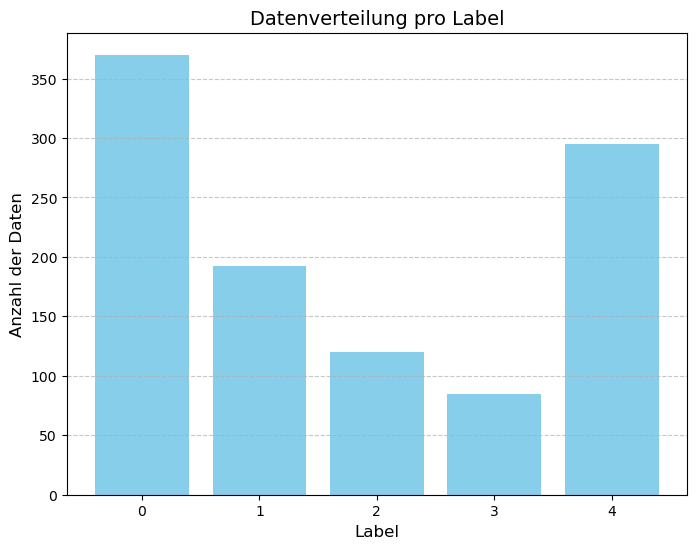

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(hf_dataset):
    # Labels aus dem Dataset extrahieren
    labels = hf_dataset["label"]
    
    # Häufigkeit der Labels zählen
    label_counts = Counter(labels)
    
    # Balkendiagramm erstellen
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Anzahl der Daten", fontsize=12)
    plt.title("Datenverteilung pro Label", fontsize=14)
    plt.xticks(ticks=list(label_counts.keys()), labels=list(label_counts.keys()), fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot erstellen
plot_label_distribution(hf_dataset)


In [27]:
# preprocessed_audio = feature_extractor(
#     arrays['X'],
#     sampling_rate = meta['sample_rate'],
#     return_tensors = "pt"
# )

# hf_dataset = Dataset.from_dict({
#     "input_values": preprocessed_audio['input_values'],
#     "label": arrays['y'],
# })

In [28]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(X=hf_dataset["input_values"], y=hf_dataset["label"], groups=augmented_groups)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(augmented_groups[train_index])}")
    print(f"  Test:  source={set(augmented_groups[test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [29]:
import transformers

batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [30]:
# select one train test split
(train_index, test_index) = next(gss.split(X=hf_dataset["input_values"], y=hf_dataset["label"], groups=augmented_groups))

In [31]:
train_ds = hf_dataset.select(train_index)

In [32]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [33]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y= hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.5741, 1.1063, 1.7700, 2.4988, 0.7200], device='cuda:0')


In [34]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [35]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,0.396200,0.597354,0.816594,0.755382,0.810549
20,0.290300,0.471886,0.847162,0.797063,0.846348
30,0.091400,0.483614,0.855895,0.808529,0.855384
40,0.088100,0.545902,0.825328,0.785122,0.824592
50,0.055600,0.498643,0.868996,0.825436,0.866870
60,0.030200,0.505670,0.842795,0.795038,0.842432
70,0.021200,0.558743,0.842795,0.801714,0.845977
80,0.010800,0.521693,0.851528,0.803401,0.849420
90,0.009100,0.542238,0.842795,0.784341,0.838795
100,0.006500,0.546036,0.842795,0.789329,0.841830


TrainOutput(global_step=105, training_loss=0.09549794044523012, metrics={'train_runtime': 451.9908, 'train_samples_per_second': 7.489, 'train_steps_per_second': 0.232, 'total_flos': 2.2043569543446528e+17, 'train_loss': 0.09549794044523012, 'epoch': 4.8})

In [36]:
pred = trainer.predict(hf_dataset.select(test_index))

## Confusionmatrix  
Die Confusionmatrix zeigt deutlich, dass die beiden Labels nun besser auseinandergehalten werden können.  
Celebration wird nun aber öfters mit Excitement verwechselt.

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        60
           1       0.50      0.62      0.55        26
           2       0.92      0.94      0.93        78
           3       0.86      0.55      0.67        33
           4       0.79      0.94      0.86        32

    accuracy                           0.84       229
   macro avg       0.80      0.79      0.79       229
weighted avg       0.85      0.84      0.84       229



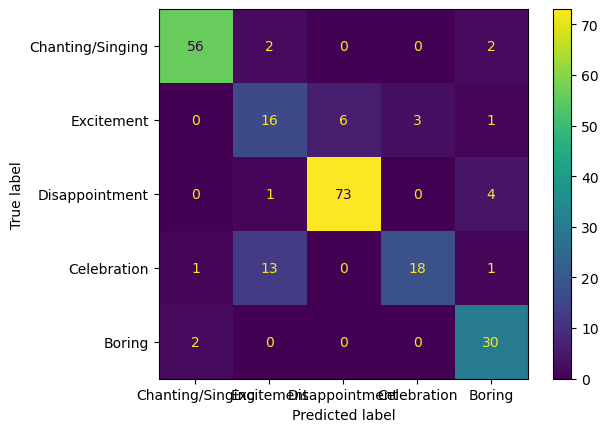

In [37]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot()

print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [41]:
id2label = {v:k for k,v in meta['labels'].items()}

In [38]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        60
           1       0.50      0.62      0.55        26
           2       0.92      0.94      0.93        78
           3       0.86      0.55      0.67        33
           4       0.79      0.94      0.86        32

    accuracy                           0.84       229
   macro avg       0.80      0.79      0.79       229
weighted avg       0.85      0.84      0.84       229



In [39]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

## Normailisierte Confusion Matrix
Diese zeigt ebenfalls die bessere Auseinanderhaltung der beiden Labels. Celebration wird aber in 39% der Fälle mit Excitement verwechselt.

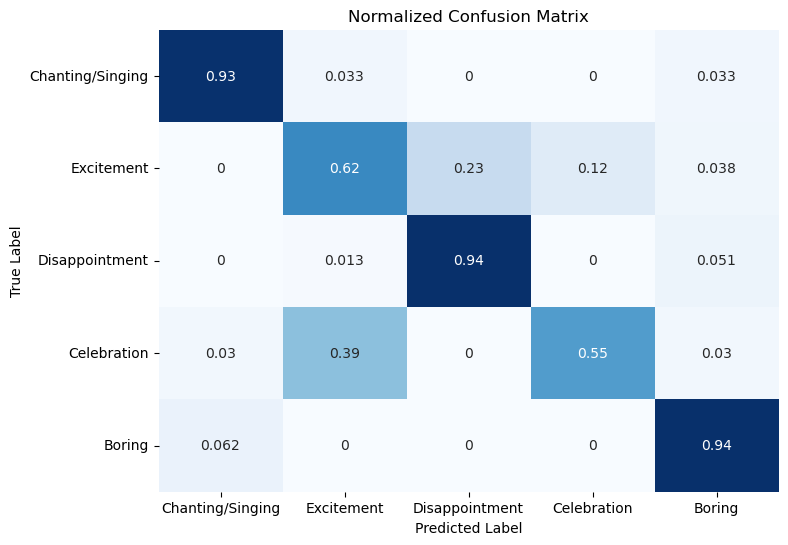

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

## Fazit
Auch wenn die Accuracy verschlechtert wurde, konnte die allgemeine Qualität des Modells, durch das Auseinanderhalten der Labels "Excitement" und "Dissapointment" verbessert werden.

Das Ausweiten der Augmentierung auf "Celebration" konnte keine bessere Leistung erzielen, weswegen nur auf Augmentierung auf "Dissapointment" und "Excitement" zurückgegriffen wurde.